In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym~=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


No GPU was detected. CNNs can be very slow without a GPU.


In [27]:
import gym
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from numpngw import write_apng
import time
import imageio
from IPython.display import Image

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Concatenate, Flatten, Input
from tensorflow.keras.models import Model, Sequential

In [229]:
from tensorflow.keras.optimizers.legacy import Adam

In [226]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [186]:
def plot_animation(frames):
    imageio.mimsave('images/cap18/a2c.gif', [np.array(img[0]) for i, img in enumerate(frames) if i%2 == 0], fps=29)
#write_apng('anim.png', frames[0], delay=20)
    img = Image(filename='images/cap18/a2c.gif')
    return img


In [162]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="rgb_array")
obs = env.reset()

c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [163]:
obs

array([0.92042255, 0.39092502, 0.8600851 ], dtype=float32)

In [241]:
actions = env.action_space.n
states = env.observation_space.shape[0]

In [242]:
actions, states

(3, 2)

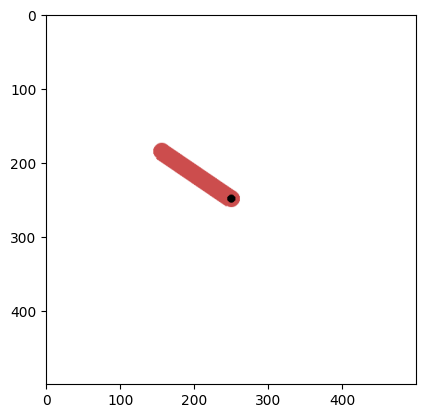

In [166]:
env.reset()
plt.imshow(env.render()[0])
plt.show()

In [169]:
def get_input(state):
    return 0 if state < 1 else 1

In [238]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
state = env.reset()
frames = []
# Run the simulation for 10 time steps
for t in range(200):
    # Render the environment
    #action = get_input(state)
    frame = env.render()
    frames.append(frame)
    # Take a random action
    #action = random.choice([0, 1])
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    

c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\imageio\plugins\pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


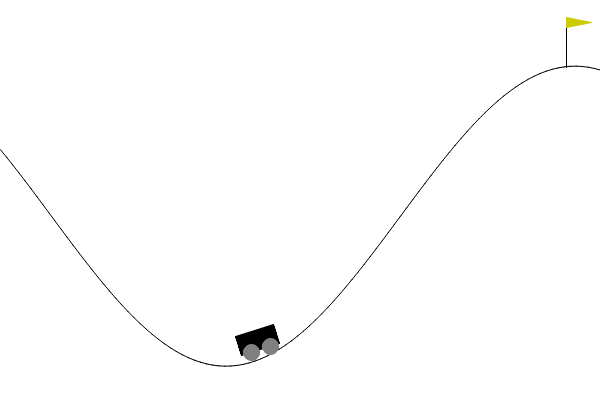

In [239]:
plot_animation(frames)

In [240]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

In [254]:
model = Sequential()
model.add(Flatten(input_shape=(1, states)))
model.add(Dense(24, activation="relu"))
model.add(Dense(24, activation="relu"))
model.add(Dense(actions, activation="linear"))

In [255]:
agent = DQNAgent(
    model=model,
    memory=SequentialMemory(limit=50000, window_length=1),
    policy=BoltzmannQPolicy(),
    nb_actions=actions,
    nb_steps_warmup=10,
    target_model_update=0.01
)

In [256]:
agent.compile(optimizer=Adam(), metrics=["mae"])

In [257]:
agent.fit(env, nb_steps=10000, visualize=False, verbose=1)

Training for 10000 steps ...
Interval 1 (0 steps performed)


c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    1/10000 [..............................] - ETA: 1:28:36 - reward: -1.0000

c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


   27/10000 [..............................] - ETA: 14:05 - reward: -1.0000

c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 13 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  batch_idx

   47/10000 [..............................] - ETA: 8:45 - reward: -1.0000

c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 29 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\rl\memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


10000/10000 [==============================] - 99s 10ms/step - reward: -1.0000
done, took 98.747 seconds


In [258]:
results = agent.test(env, nb_episodes=10, visualize=True)

Testing for 10 episodes ...


c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200
Episode 6: reward: -200.000, steps: 200
Episode 7: reward: -200.000, steps: 200
Episode 8: reward: -200.000, steps: 200
Episode 9: reward: -200.000, steps: 200
Episode 10: reward: -200.000, steps: 200


In [259]:
agent.test(env)

Testing for 1 episodes ...
Episode 1: reward: -200.000, steps: 200


In [260]:
print(np.mean(results.history["episode_reward"]))

-200.0


<Axes: >

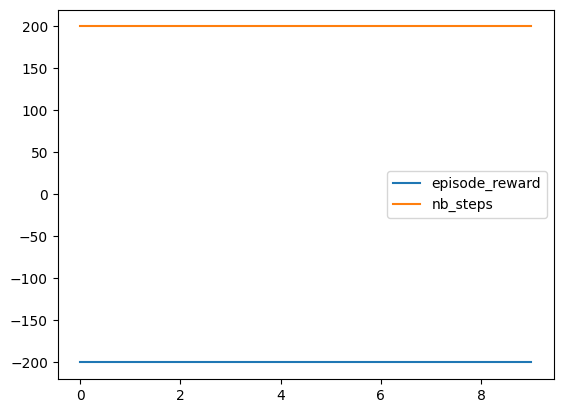

In [261]:
pd.DataFrame(results.history).plot()

In [262]:
env.close()

In [263]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
frames = []

episodes = 10
for episode in range(episodes + 1):
    done = False
    score = 0
    obs = env.reset()
    while not done:
        frame = env.render()
        action = agent.forward(obs) #random.choice([0, 1])
        obs, reward, done, info = env.step(action)
        score += reward
        frames.append(frame)

    print(f"Episode {episode} Score {score}")


c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 0 Score -200.0
Episode 1 Score -200.0
Episode 2 Score -200.0
Episode 3 Score -200.0
Episode 4 Score -200.0
Episode 5 Score -200.0
Episode 6 Score -200.0
Episode 7 Score -200.0
Episode 8 Score -200.0
Episode 9 Score -200.0
Episode 10 Score -200.0


c:\Users\franc\Documents\Classes\Mãos à Obra Aprendizado de Máquina\.venv\Lib\site-packages\imageio\plugins\pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


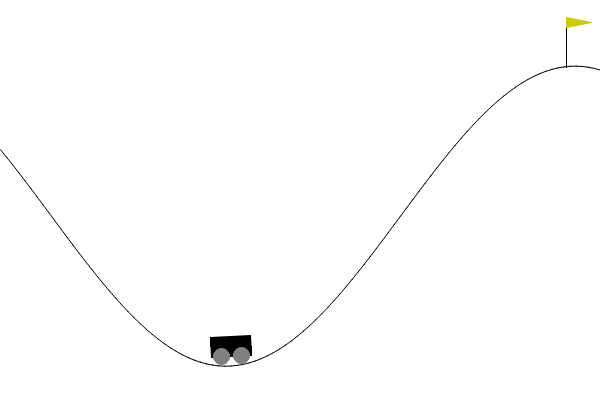

In [264]:
plot_animation(frames)